# TP4 : model-free RL 

Jusqu'à lors, nous avons étudié des cas où le modèle de la matrice de transition et de la récompense étaient modélisés : c'est le cadre du *model-based reinforcement learning*. 
Pour gérer des cas plus complexes, nous devons soulager ces hypothèses. Dans le *model-free reinforcement learning*, on regarde les expériences passées, échecs comme réussites, pour simuler le modèle sous-jacent.

Ce TP propose d'implémenter plusieurs algorithmes allant dans ce sens.


RAPPEL : 1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [1]:
! pip install numpy matplotlib 'gym[toy_text, classic_control]'
# Pour gérer les dépendances de PyGame: https://www.pygame.org/wiki/Compilation
# A cause de PyGame, la version de Python doit être inférieure à 3.10 !

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 147 kB/s 


In [2]:
%load_ext autoreload
%autoreload 2
import random
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
    
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import gym


bash: ../xvfb: No such file or directory
env: DISPLAY=:1


## Présentation de Gym
Dans ce TP, nous allons le simulateur Gym par Open AI. Gym fournit une série d'environnements qui ont permis aux chercheurs de se comparer et ainsi, de faire accélérer la recherche en reinforcement learning.

In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array", new_step_api=True)

env.reset()
for _ in range(10):
    env.render()
    env.step(env.action_space.sample()) # Take a random action

**Q1. Décrire l'environnement Taxi. En particulier, vous vous demanderez quel est l'espace d'action ? Des états ? Comment est définie la récompense ? Que contient l'output de `env.step` ?**

La documentation de cet environnement est disponible ici:
    [https://www.gymlibrary.dev/api/core/#gym.Env.step](https://www.gymlibrary.dev/api/core/#gym.Env.step)

### Actions possibles:
- 0: déplacement Sud
- 1: déplacement Nord
- 2: déplacement Est
- 3: déplacement Ouest
- 4: Récupérer un passager
- 5: Déposer un passager

### Récompenses
- -1 par step sauf s'il y a une nouvelle récompense.

- +20 pour déposer un passager.

- -10 Récupérer et déposer illégalement un passager.

### Etats possibles

Il y a 500 états possibles dont 25 positions, 5 emplacements possibles pour le passager (y compris dans le taxi), et 4 destinations.

400 états peuvent être atteints en un épisode. Les autres états réprésentent la situation où le passager est à leur emplacement de destination (fin de l'épisode). 4 autres états représentent le taxi et le passager à destination. Cela donne un total de 404 états discrets.

Chaque état est représenté par le tuple : (`taxi_row`, `taxi_col`, `passenger_location`, `destination`)

Emplacements du passager:

- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: dans le taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

### Etape `env.step()`

Cette opération renvoie 5 valeurs:
- `observation` : état après étape
- 
- a
- a
- `info`

## Q-Learning

Dans cette partie, nous allons utiliser le Q-Learning pour résoudre cette tâche.

mean reward -9.03


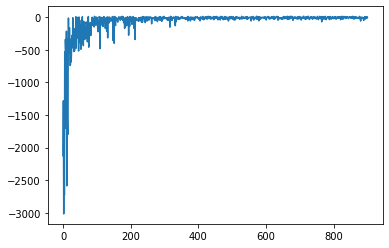

In [11]:
from qlearning import QLearningAgent

env = gym.make("Taxi-v3", render_mode="rgb_array", new_step_api=True)
n_actions = env.action_space.n

agent = QLearningAgent(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

def play_and_train(env: gym.core.Env, agent: QLearningAgent, t_max=int(1e4)) -> float:
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total rewardb
    """
    total_reward = 0.0
    s, info = env.reset(return_info = True)
    
    for t in range(t_max):
        # TODO get agent to pick action given state s
        a = agent.get_action(s)
        
        next_s, r, done, truncated, info = env.step(a)
        
        if isinstance(next_s, np.ndarray):
            next_s = tuple(next_s)

        # TODO train agent for state s
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i % 100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

**Q2. Complétez les bouts manquants de code dans `qlearning.py` et dans la fonction `play_and_train`. Entrainez l'agent. Que se passe-t'il ? Regardez des exemples de trajectoire.**

## Réduire epsilon au-fur-et-à-mesure

Pour améliorer les performances, nous allons réduire $\epsilon$ au cours du temps.

La manière la plus simple consiste à réduire $\epsilon$ à chaque épisode, par exemple en le multipliant par un nombre proche de 1 (tel que 0.99) ou lui soustraire un pettit nombre. Vous pouvez, bien sûr, envisager d'autres stratégies !

**Q3. Améliorez l'algorithme dans `q_learning_eps_scheduling.py` de sorte à avoir une récompense positive**

mean reward 7.58


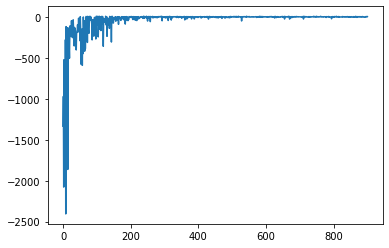

In [12]:
from qlearning_eps_scheduling import QLearningAgentEpsScheduling

agent = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

*[Ajoutez votre réponse ici]*

**Q4. Produisez quelques vidéos des trajectoires obtenus. Rassemblez des cas de réussite et des cas d'échecs**

## Espace d'action continu

Nous allons maintenant passer à un environnement plus difficile : le pendule inversé. C'est un grand classique des problèmes de contrôle !

Puisque l'environnement a un espace d'actions continu, nous allons discrétiser cet espace pour revenir aux cas précédemment étudiés.
La solution la plus simple pour cela consiste à diviser l'espace en sections égales. Mais comment choisir le nombre de sections ?

first state:  [ 0.04940362  0.03035493 -0.0021732   0.00910792]


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


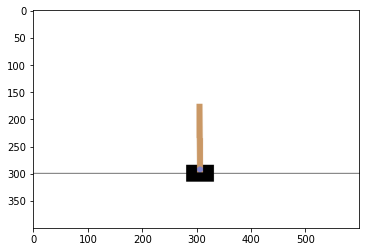

In [13]:
env = gym.make("CartPole-v1", render_mode="rgb_array", new_step_api=True)
n_actions = env.action_space.n

print("first state: ", env.reset())
plt.imshow(env.render()[0])

**Q5. Décrivez cet environnement à l'aide de la documentation de Gym en reprenant la Q1.**

*Va dé rétro satanas*

Pour mener à bien notre discrétisation de l'espace des actions, nous allons estimer la distribution des observations.

**Q6. Simulez 1000 épisodes et regardez la distribution des états à l'aide d'un histogramme. Quel paramètre vous paraît optimal pour choisir le nombre de `bins` ?**

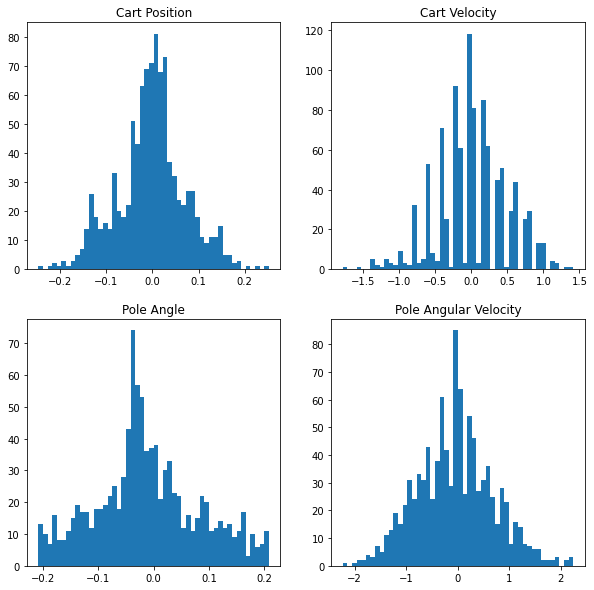

In [18]:
env.action_space.seed(42)

observation, info = env.reset(seed=42, return_info=True)
obs_list = []

for _ in range(1000):
    observation, reward, terminated, truncated = env.step(env.action_space.sample())

    if terminated or truncated:
        observation, info = env.reset(return_info=True)
    obs_list.append(observation)

obs_list = np.array(obs_list)

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].hist(obs_list[:,0], bins=50)
axs[0,0].set_title("Cart Position")

axs[0,1].hist(obs_list[:,1], bins=50)
axs[0,1].set_title("Cart Velocity")

axs[1,0].hist(obs_list[:,2], bins=50)
axs[1,0].set_title("Pole Angle")

axs[1,1].hist(obs_list[:,3], bins=50)
axs[1,1].set_title("Pole Angular Velocity")

plt.show()

*On observe une distribution Binomiale des différents paramètres*

## Discrétiser l'environnement

In [ ]:
from gym.core import ObservationWrapper

def _discretize_range(lower_bound, upper_bound, num_bins):
    return np.linspace(lower_bound, upper_bound, num_bins + 1)[1:-1]

class Binarizer(ObservationWrapper):
    def _observation(self, state: np.ndarray) -> np.ndarray:  
        # TODO binarize each dimension of the state
        state = np.ndarray([np.histogram(elem, 50)[0] for elem in state])

        return state
    
bi_env = Binarizer(gym.make("CartPole-v0"))

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**Q7. Complétez le code ci-dessus pour binariser l'environnement. Regardez la nouvelle distribution des états. Qu'en pensez-vous ?**

*[Ajoutez votre réponse ici]*

### Apprentissage sur l'environnement discretisé

**Q8. Reprenez votre agent pour résoudre cette tâche. Tracez la récompense et observez quelques trajectoires d'échecs et de réussites à l'aide de vidéos**

*[Ajoutez votre réponse ici]*

## 4. Experience replay 

Les algorithmes *off-policy* peuvent s'entraîner grâce à des trajectoires anciennement obtenues. Tirons parti de cette propriété pour 
améliorer l'efficacité de nos algorithmes et les permettre de converger plus rapidement.

L'idée générale est de collecter les tuplets `<s,a,r,s'>` dans un *buffer*, puis de mettre à jour la fonction Q sur l'ensemble de ces tuplets.
Plus en détails, voici l'algorithme à suivre

#### S'entraîner avec un *experience replay*
1. Echantillonner un tuplet `<s,a,r,s'>`.
2. Stocker ce tuplet dans un buffer FIFO : si le buffer est plein, on supprimer les données arrivées en premier.
3. Choisir aléatoirement K tuplets du buffer et mettre à jour la fonction Q sur ces tuplets.

**Q9. Implémentez un tel buffer**

In [ ]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
            
        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self.size = size

# Some tests to make sure your buffer works right

replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1) == obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj1
print("Success!")

Maintenant utilisons ce replay buffer pour améliorer les performances d'entraînement.

**Q10. Entraînez un agent avec le replay buffer. Comparez l'évolution de la récompense sur l'environnement Taxi avec un algorithme n'utilisant pas le replay buffer.**

Pour rendre l'affichage plus visible, vous filterez la récompense avec un filtre de votre choix.

In [ ]:
agent_baseline = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

agent_replay = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

replay = ReplayBuffer(10000)

def play_and_train(
    env: gym.core.Env, 
    agent: QLearningAgent, 
    t_max: int = int(1e4),
    batch_size: int = 32
) -> float:
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total rewardb
    """
    total_reward = 0.0
    s, info = env.reset()
    
    for t in range(t_max):
        # TODO get agent to pick action given state s
        a = 0
        
        next_s, r, done, truncated, info = env.step(a)
        
        # TODO train agent for state s
        # ...
        if replay is not None:
            # TODO update this part
            pass
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward

*[Ajoutez votre réponse ici]*